In [1]:
import numpy as np
import tensorflow as tf
import os
from random import shuffle
import matplotlib.pyplot as plt

In [2]:
#Source directories
s_dir = "/home/vishnu/TFlow_ws/CameraProj/MLData/Smile"
o_dir = "/home/vishnu/TFlow_ws/CameraProj/MLData/Other"

In [3]:
#Image Preprocessing functions
def get_files(Sdir,Odir):
    filelist = [Sdir+"/"+x for x in os.listdir(Sdir)]+[Odir+"/"+y for y in os.listdir(Odir)]
    shuffle(filelist)
    label = [1 if x.find('Smile') != -1 else 0 for x in filelist]
    return filelist, label

#Parses function for data_array iterator
def _parse_fun(filename,labels):
    image_string = tf.read_file(filename,name="read_files")
    image_decode = tf.image.decode_jpeg(image_string,channels=1)
    image = tf.cast(image_decode,tf.float32,name="cast_f32")
    image = tf.image.per_image_standardization(image)
    one_hot = tf.one_hot(labels,2)
    
    #return dataset,labels
    return image,one_hot

#Parse function for data augment iterator
def data_augment(filename,labels):
    
    image_string = tf.read_file(filename,name="read_files_data_aug")
    image_decode = tf.image.decode_jpeg(image_string,channels=1)
    image = tf.cast(image_decode,tf.float32,name="cast_image_f32")
    image = tf.image.per_image_standardization(image)
    
    #Creating image mirror
    mirror_img = tf.image.flip_left_right(image)
    one_hot = tf.one_hot(labels,2)
    
    #Fine angle rotations
    
    
    #Scaling
    
    #Noise
    return [image,mirror_img], one_hot

In [4]:
#Defining some functions for developing network model

#Weight_variables
def weight_variable(shape,m_name):
    initial = tf.truncated_normal(shape,stddev=0.1)#.1
    return tf.Variable(initial,name=m_name)

#Bias Variable
def bias_variable(shape,m_name):
    initial = tf.truncated_normal(shape,stddev=0.1)
    return tf.Variable(initial,name=m_name)

#Conv
def conv2d(x,W,m_name):
    return tf.nn.conv2d(x,W,strides=[1,1,1,1],padding='SAME',name=m_name)

#max_pool_5x5
def max_pool(x,m_ksize,m_kstrides,m_name):
    return tf.nn.max_pool(x,ksize=[1,m_ksize,m_ksize,1],strides=[1,m_kstrides,m_kstrides,1],padding='SAME',name=m_name)


In [5]:
#Data Augmentation section

#Reading file names
filename,labels = get_files(s_dir,o_dir)

#Creating Dataset
dataset_aug = tf.data.Dataset.from_tensor_slices((filename,labels))
#Processing data with the data_augment function
dataset_aug = dataset_aug.map(data_augment)

#Declaring iterator
it = tf.data.Iterator.from_structure(dataset_aug.output_types,dataset_aug.output_shapes)
it_op = it.make_initializer(dataset_aug)

x,y_ = it.get_next()
#Variable initialize operation
init_op = tf.global_variables_initializer()

In [6]:
#Data Array contains the augmented data.
data_array = []

with tf.Session() as sess:
    sess.run(init_op)
    sess.run(it_op)
    
    while True:
        try:
            rtn,yy = sess.run([x,y_])
            data_array.append([rtn[0],yy])
            data_array.append([rtn[1],yy])
            
            #mp = {"img": rtn[0],"label": y_}
            #data_array.append(mp)
            #mp = {"img": rtn[1],"label" :y_}
            #data_array.append(mp)
        except tf.errors.OutOfRangeError:
            print("Finished")
            break

    #tf.summary.FileWriter("logs",sess.graph).close()
shuffle(data_array)
#shuffle(data_array)

Finished


In [7]:
length = len(data_array)
third = 2*int(length/3)

data_array = np.array(data_array)

Train_data = data_array[:third][:,0]
Train_data_labels = data_array[:third][:,1]
Test_data = data_array[third:][:,0]
Test_data_labels = data_array[third:][:,1]

x = tf.placeholder(tf.float32,shape=[50,50,1],name="x")
y_ = tf.placeholder(tf.float32,shape=[1,2],name="y_")


#dataset_train = tf.data.Dataset.from_tensor_slices((features_placeholder,labels_placeholder))

In [8]:
k_size = 5
conv1_feat = 32
conv2_feat = conv1_feat*2
fc2_i_nodes = 300#fc input nodes
fc2_o_nodes = 100 #fc output nodes
fc3_i_nodes = 2

#Layer 1 variables
w_conv1 = weight_variable([k_size,k_size,1,conv1_feat],"w_conv1")
b_conv1 = bias_variable([conv1_feat],"b_conv1")

#Layer 2 variables
w_conv2 = weight_variable([k_size,k_size,conv1_feat,conv2_feat],"w_conv2")
b_conv2 = bias_variable([conv2_feat],"b_conv2")

#Fully connected Layers
w_fc1 = weight_variable([k_size*k_size*conv2_feat,fc2_i_nodes],"w_fc1")
b_fc1 = bias_variable([fc2_i_nodes],"b_fc1")
w_fc2 = weight_variable([fc2_i_nodes,fc2_o_nodes],"w_fc2")
b_fc2 = bias_variable([fc2_o_nodes],"b_fc2")
w_fc3 = weight_variable([fc2_o_nodes,2],"w_fc3")
b_fc3 = bias_variable([2],"b_fc3")
w_fc4 = weight_variable([fc3_i_nodes,1],"w_fc4")
b_fc4 = bias_variable([1],"b_fc3")

#Keep probability
keep_prob = tf.placeholder(tf.float32,name="keep_prob")


#Connecting the layers
x_img = tf.reshape(x,[1,50,50,1],name="Reshaping_x")

h_conv1 = tf.nn.relu(conv2d(x_img,w_conv1,"relu_hconv1")+b_conv1,name="h_conv1")
#h_conv1 = tf.nn.relu(conv2d(Train_image,w_conv1,"relu_hconv1")+b_conv1,name="h_conv1")
#h_pool1 = max_pool(h_conv1,2,2,"h_pool1")
h_pool1 = max_pool(h_conv1,5,5,"h_pool1")

h_conv2 = tf.nn.relu(conv2d(h_pool1,w_conv2,"relu_h_conv2")+b_conv2)
h_pool2 = max_pool(h_conv2,2,2,"h_pool2")

h_pool2_flat = tf.reshape(h_pool2,[1,k_size*k_size*conv2_feat])
h_fc1 = tf.nn.relu(tf.matmul(h_pool2_flat,w_fc1)+b_fc1)
h_fc1_drop = tf.nn.dropout(h_fc1,keep_prob,name="h_fc1_drop")
h_fc2 = tf.nn.relu(tf.matmul(h_fc1_drop,w_fc2)+b_fc2)
h_fc2_drop = tf.nn.dropout(h_fc2,keep_prob,name="h_fc2_drop")
#y_conv = tf.nn.sigmoid(tf.matmul(h_fc2_drop,w_fc3,name="y_conv")+b_fc3,name="y_c")
h_fc3 = tf.nn.relu(tf.matmul(h_fc2_drop,w_fc3,name="matmul_3")+b_fc3)
h_fc3_drop = tf.nn.dropout(h_fc3,keep_prob,name="h_fc3_drop")
#y_conv = tf.nn.sigmoid(tf.matmul(h_fc3_drop,w_fc4,name="y_conv")+b_fc4,name="y_c")
y_conv = tf.matmul(h_fc3_drop,w_fc4,name="y_conv")+b_fc4

In [9]:
#Training
#loss_fun = tf.nn.softmax_cross_entropy_with_logits(labels=y_,logits=y_conv,name="loss_fun")
#cross_entropy = tf.reduce_mean(loss_fun,name="cross_entropy")
#train_step = tf.train.GradientDescentOptimizer(.001).minimize(cross_entropy)
#train_step = tf.train.AdamOptimizer(.0001).minimize(cross_entropy)

#correct_prediction = tf.equal(tf.argmax(y_conv,1),tf.argmax(y_,1))
#accuracy = tf.reduce_mean(tf.cast(correct_prediction,tf.float32))

#init_op = tf.global_variables_initializer()


#loss = -(y_ * tf.log(y_conv + 1e-12) + (1 - y_[0]) * tf.log( 1 - y_conv + 1e-12))
#print(Train_data_labels[0][0])
loss = tf.nn.sigmoid_cross_entropy_with_logits(labels=y_[0][0],logits=y_conv[0][0],name="loss")
#cross_entropy = tf.reduce_mean(tf.reduce_sum(loss))
#train_step = tf.train.AdamOptimizer(.0001).minimize(cross_entropy)
train_step = tf.train.AdamOptimizer(.0001).minimize(loss)

predict_is_smile = tf.greater(y_conv,0.5)
correct_prediction = tf.equal( tf.to_float(predict_is_smile), y_[0],name="correct_prediction" )







#y_cc = tf.nn.sigmoid(y_conv,name = "y_cc")
#loss_fun = tf.nn.softmax(logits=y_cc,name="loss_fun")
#loss_fun = tf.nn.sigmoid(y_conv,name="loss_fun")
#cross_entropy = tf.reduce_mean(loss_fun,name="cross_entropy")
#train_step = tf.train.AdamOptimizer(0.0001).minimize(cross_entropy)



#correct_prediction = tf.equal(tf.argmax(y_conv,1),tf.argmax(y_,1),name="correct_prediction")
#accuracy = tf.reduce_mean(tf.cast(correct_prediction,tf.float32))


init_op = tf.global_variables_initializer()


#cov = [[smilesmile, smilenosmile],[nosmilesmile nosmilenosmile]]

1332
0.481981981982


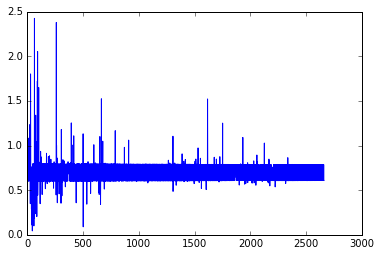

In [11]:
cor = 0
t = []
lo = []
with tf.Session() as sess:
    sess.run(init_op)
    for i in range(len(Train_data)):
        l = Train_data_labels[i].reshape(1,2)
        a,b = sess.run([train_step,loss],feed_dict={x: Train_data[i],y_: l,keep_prob: .5})
        t.append(i)
        lo.append(b)
        
    for i in range(len(Test_data)):
        cp = Test_data_labels[i]
        l = Test_data_labels[i].reshape(1,2)
        #val = sess.run(accuracy,feed_dict={x: Test_data[i],y_: l,keep_prob: 1.0})
        #print(cp.argmax(),val)
        val = sess.run([loss],feed_dict={x: Test_data[i],y_: l,keep_prob: 1.0})
        #print(cp.argmax(),val[0].argmax())
        #print(val)
        if (cp.argmax() == val[0].argmax()):
            cor = cor+1
        
    #tf.summary.FileWriter("logs",sess.graph).close()

N = len(Test_data)
print(N)
acc = (float(cor)/N)
print(acc)

plt.plot(t,lo)
plt.show()

In [17]:
"""
filenames,labels = get_files(s_dir,o_dir)

length = len(filenames)
third = int(length/3.0)

Train_names = filenames[:third]
Train_labels = labels[:third]
Test_names = filenames[third:]
Test_labels = labels[third:]

dataset_train = tf.data.Dataset.from_tensor_slices((Train_names,Train_labels))
dataset_train = dataset_train.map(_parse_fun)
#dataset_train = dataset_train.batch(10)


dataset_test = tf.data.Dataset.from_tensor_slices((Test_names,Test_labels))
dataset_test = dataset_test.map(_parse_fun)
#dataset_test = dataset_test.batch(10)


iterator = tf.data.Iterator.from_structure(dataset_train.output_types,dataset_train.output_shapes)

training_init_op = iterator.make_initializer(dataset_train)
testing_init_op = iterator.make_initializer(dataset_test)

x, y_ = iterator.get_next()"""

'\nfilenames,labels = get_files(s_dir,o_dir)\n\nlength = len(filenames)\nthird = int(length/3.0)\n\nTrain_names = filenames[:third]\nTrain_labels = labels[:third]\nTest_names = filenames[third:]\nTest_labels = labels[third:]\n\ndataset_train = tf.data.Dataset.from_tensor_slices((Train_names,Train_labels))\ndataset_train = dataset_train.map(_parse_fun)\n#dataset_train = dataset_train.batch(10)\n\n\ndataset_test = tf.data.Dataset.from_tensor_slices((Test_names,Test_labels))\ndataset_test = dataset_test.map(_parse_fun)\n#dataset_test = dataset_test.batch(10)\n\n\niterator = tf.data.Iterator.from_structure(dataset_train.output_types,dataset_train.output_shapes)\n\ntraining_init_op = iterator.make_initializer(dataset_train)\ntesting_init_op = iterator.make_initializer(dataset_test)\n\nx, y_ = iterator.get_next()'

In [16]:
cal = [[1 ,1],[1 ,1]]
cal[0][0] = 0
cal[0][1] = 0
cal[1][0] = 0
cal[1][1] = 0
with tf.Session() as sess:
    sess.run(init_op)
    sess.run(training_init_op)
    #tf.summary.FileWriter("logs",sess.graph).close()
    while True:
        try:
            #img = sess.run(Train_image)
            sess.run([x,y_])
            sess.run(train_step,feed_dict={keep_prob: 0.5})
        except tf.errors.OutOfRangeError:
            print("Finished Training")
            break
    
    sess.run(testing_init_op)
    
    while True:
        try:
            t_img,t_label = sess.run([x,y_])
            l = t_label
            val = sess.run(accuracy, feed_dict={keep_prob: 1.0})
            if (l.argmax() == val):
                cal[0][0] = cal[0][0]+1
            elif l.argmax() == 1 and val == 0:
                cal[1][0] = cal[1][0]+1
            elif l.argmax() == 0 and val == 1:
                cal[0][1] = cal[0][1]+1
            else:
                cal[1][1] = cal[1][1]+1
        except tf.errors.OutOfRangeError:
            print("Finished Testing")
            break
                
print(cal)
N = len(Test_labels)
print(N)
total_correct = cal[0][0]+cal[1][1]
acc = (float(total_correct)/N)
print(acc)

Finished Training
Finished Testing
[[338, 159], [168, 0]]
1331
0.253944402705
